# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


## Disclaimer
Some of the cells have been taken from different notebooks because they were running in parallel. This is why sometimes the execution numbers might be incoherent. In any case the notebook is executable in one go with no problem.

## Notebook Constants

In [11]:
checkpoint_filepath = './DeepLearning/transformers_checkpoints/'
VOCABULARY_SIZE = 10000
SENTENCE_LENGTH = 32

In [12]:
colab = False
if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  checkpoint_filepath = '/content/drive/MyDrive/DeepLearning/transformers_checkpoints/'

## Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [2]:
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

\u001bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv\u001b\u001b
\u001bRequirement already satisfied: protobuf~=3.20.3 in /opt/conda/lib/python3.10/site-packages (3.20.3)
\u001bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv\u001b\u001b
\u001b\u001bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv\u001b\u001b
\u001b\u001bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use

In [3]:
!pip install datasets
!pip install apache-beam
!pip install gdown
!pip install plot_keras_history
!pip install keras-nlp

\u001bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv\u001b\u001b
\u001bRequirement already satisfied: apache-beam in /opt/conda/lib/python3.10/site-packages (2.46.0)
\u001b[2K     \u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b \u001b152.0/152.0 kB\u001b \u001b5.4 MB/s\u001b eta \u001b0:00:00\u001b
\u001b[?25h  Preparing metadata (setup.py) ... \u001b[?25ldone
\u001b[?25hRequirement already satisfied: cloudpickle~=2.2.1 in /opt/conda/lib/python3.10/site-packages (from apache-beam) (2.2.1)
\u001b[2K     \u001b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\u001b \u001b35.3/35.3 MB\u001b \u001b38.2 MB/s\u001b eta \u001b0:00:00\u001b00:01\u001b00:01\u001b
\u001b[?25hRequirement already satisfied: docopt in /opt/conda/lib/python3.10/site-packages (from hdfs<3.0.0,>=2.1.0->apache-beam) (0.6.2)
\u001b[?25h  Created wheel f

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
from time import time
from math import floor
from random import Random
from datasets import load_dataset

import numpy as np 
import pickle
import gdown
import random
import tensorflow as tf

In [14]:
# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [15]:
dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=VOCABULARY_SIZE, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]

# Tokenization 
tokenizer.fit_on_texts(corpus)

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= SENTENCE_LENGTH and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


In [17]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [18]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 1167, 1913, 9, 60, 2321, 7, 4, 240, 16, 10, 365, 203, 9234, 1528, 1530, 3]
shuffled sentecen:  [2, 1913, 240, 2321, 203, 365, 1530, 4, 9, 9234, 10, 7, 1167, 60, 1528, 16, 3]


Let us look at detokenized data:

In [19]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> margaret was married to otto i of burgundy <end>
shuffled sentence:  <start> burgundy of i otto married margaret to was <end>


Train - test split.
Reserve at least 30% of data for testing.


In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)

Input padding

In [21]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [22]:
assert(len(x_train)==len(c_train)==len(y_train))
print("Train shape:", x_train.shape)
print("Test shape: ", x_test.shape)

Train shape: (96110, 32)
Test shape:  (41191, 32)


Distribution of data w.r.t. their lenght.

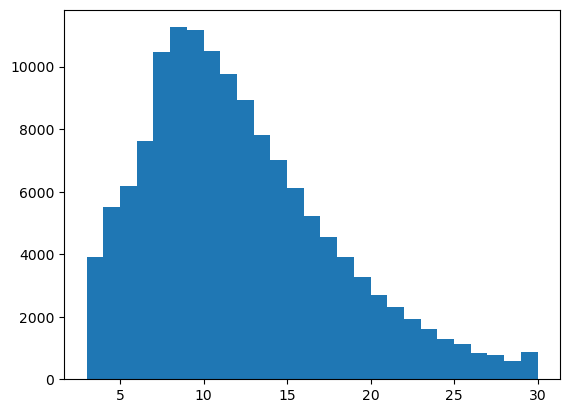

In [23]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27);

## Metric Definition
Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [24]:
from difflib import SequenceMatcher

def score(s: str, p: str):
  match_ = SequenceMatcher(None, s, p).find_longest_match()
  return (match_.size/max(len(s), len(p)))

The score must be computed as an average of at least 10K random examples taken form the test set.

## Model

We want to use a modified transormer model. The difference between a regular tranformer and the one we're going to implement is the fact that in the input sequence we don't need any form of positional encoding. This is because our input is scambled at random and the network should not care about the position of each token.

In addition to this change a proxy has been introduced for the inference part that mask out all the unwantend tokens that the network might try to generate. This final "layer" will be discussed in more detain when we define the Transformer class.

The code for defining the transtormer has been taken and adapted from https://www.tensorflow.org/text/tutorials/transformer

First of all we define a new layer for input embedding with position.
This layer wants in input the size of the vocabulary (10K in our case), and the length of the input (32 in our case).
What it does is computing a positional encoding using resonating sin and cos, create input embedding, and than adding everything togheter.

In [25]:
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = self.positional_encoding(length=2048)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]

    return x

  def positional_encoding(self, length):
    depth = self.d_model/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

Here we define the attention layers.

In [26]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x


class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

Here we define the feed forward layer with residual connections and layer normalization

In [27]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='gelu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

Now that we have defined the building blocks of the transformers we can move on and create the encoder layer. 

Here we take the global self attention layer and the feed forward layer and we stack them to form the encoder layer.
This will be stacked as many times as we decide to form the actual encoder.

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

Here we define the actual encoder.

This is the first divergence from a classical transformer. In fact here we omit the positional embedding and just use a classical embedding. Why this is useful? Because without a positional embedding the network is simply getting a bag of words without any information on the position of the single words, and this is what we want. Now we are independent from the shuffuling and the network doen't need to understand it by its own.

In [29]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Regular Embedding (NOT POSITIONAL)
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    x = self.embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x

Here we define the decoder layer that like the encoder's one will be repeated as many time as we want to form the acctual decoder.

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    x = self.ffn(x)
    return x

Here we define the actual decoder.

We just use the embedding and the decoder layer. This layer should not be modified for our specific task and it's good as is.

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    return x

Now we can create the actual transformer.

The implementation of the transformer has been changed in order to include what we know about the problem. We know that the output of our model should be a reordered sentence starting from the shuffled one, so we can safely say that we need to restrict the set of words that the transformer should output, if we don't do this any words can be used and we could incur in some wrong prediction.

But with this approach there is a limitation: the network is free to choose a word as many times as it likes regardless of the shuffled sequence. This is bad because if we use a word more that in the input we already know that we're making a mistake. To avoid this a "smarter" mask have been introduced. Essentially what it does is compute the number of each available tokens at each point in the sequence and mask out all the tokens that have already been consumed in the sentence. Doing this ensures that we're using the correct number of of each word. Mind that the network is free to cut the predicted sentence by adding a \<end\> token before all the words have been used. For a more detailed description of the implementation please refer to the commented code below.

Now that we have this mask wouldn't be more reasonable to use it even when training? The answer is no and the reasoning behind is not something that I can prove.

The idea is that when we're training having a mask like this is a problem for the loss function. Essentially the network doesn't know anything about this layer because it has no learnable parameters, it's not differentiable, and it's doing a non linear operation. The loss function then will be computed only on the restricted set of words that changes for every sentence and the rest of the network output is not considered. 

For example if the logits of the dense layer are [10, 5, 3, 23, 7] and the sentence only includes tokens 2, 4 we end up with an output of [0, 0, 3, 0, 7] completely omitting the fact that we're giving a very high score to a word that doesn't make sense. We're simply not letting the network know what is doing wrong outside the allowed tokens.

But then why is this a problem if we always use the mask? Because if in the test set there is novelty the network is not able to generalize well and it will incur in wrong prediction thus lowering the final score. Our objective in the training is to get a network that understands the relationships in language and to effectively doing this it needs the freedom of choosing all the words.

In [32]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_enc_layers, num_dec_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_enc_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_dec_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, use_mask=False):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context = inputs[0]
    x = inputs[1]
    
    if use_mask:

        # OLD MASK
        # ohe_context = tf.one_hot(context, depth=VOCABULARY_SIZE)
        # mask = tf.reduce_any(tf.cast(ohe_context, dtype=tf.bool), axis=1)
        # mask = tf.tile(tf.expand_dims(mask, axis=1), [1, SENTENCE_LENGTH, 1])

        # --- MASKING ---
        # To mask using x we first need the 1HE of each sentence in the batch, shape (batch_size, seq_len, 1he_len)
        ohe_x = tf.one_hot(x, depth=VOCABULARY_SIZE)
        ohe_context = tf.one_hot(context, depth=VOCABULARY_SIZE)

        # Now we need to sum them to get again a shape of (batch_size, seq_len, 1he_len)
        # This is because what we want is to have a cumulative sum that at each position of the sentence
        # indicates what words have been used until that point
        # if we have something like [2, 10, 47, 3]
        # we expect [[2], [2, 10], [2, 10, 47], [2, 10, 47, 3]] but instead of using raw indexes we use 1HE
        # to keep the shape at (batch_size, seq_len, 1he_len)
        cum_x = tf.cumsum(ohe_x, axis=1)

        # Once we have that matrix we need to know if we're under the limit of the words or not.
        # To do this we need to sum the 1HE of the shuffled sentences
        count_context = tf.math.reduce_sum(ohe_context, axis=1)

        # Now we need that count_context match the dimensions of cum_x, because now its (batch_size, 1, 1he_len)
        count_exp_context = tf.tile(tf.expand_dims(count_context, axis=1), [1, SENTENCE_LENGTH, 1])

        # Once we have this we can simply check if the x mask is < than the shuffled mask
        # Doing so we output a tensor that has true if we can use that token again in the sentence
        mask = cum_x < count_exp_context
        # --- END MASKING ---
    
    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    
    if use_mask:
        # Mask logits to use only the word we want and to all the possible words
        logits = tf.multiply(logits, tf.cast(mask, dtype=tf.float32))
    
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

## Hyperparameters

We define the following hyperparameters:
- `num_layers`: the number of encoder and decoder layers to use
- `d_model`: the dimensionality of the embeddings
- `dff`: the dimension of the dense layers in the ff layers
- `num_heads`: number of self attention heads
- `dropout_rate`: rate that is used in the dropout layers

After some evaluations I found the following as the best performing parameters.

In [33]:
num_enc_layers = 8
num_dec_layers = 8
d_model = 128
dff = 1024
num_heads = 4
dropout_rate = 0.1

EPOCHS = 200
BATCH_SIZE = 128

learning_rate = 0.0005

## Training

In the original paper "Attention is all you need" a custom LR scheduler has been proposed. This gave a good starting point for our LR but to fine tune the model we need a reduction based on the validation accuracy, this is why I fixed the LR and not use the scheduler.

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

We need to define a masked version of the loss (`SparseCategoricalCrossentropy`) because the target sequences are padded.

In [35]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Callback definition.

We just use them to stop the training or reduce the LR if the accuracy is not improving.

In [90]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + 'callback_checkpts/' + f'{floor(time())}/' +'weights.{epoch:02d}-{val_masked_accuracy:.4f}.hdf5',
    save_weights_only=True,
    monitor='val_masked_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=5
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_masked_accuracy', 
    factor=0.2,
    verbose=1,
    patience=3,
    min_lr=0.0000001,
    mode='max',
    min_delta=0.001
)

Model creation

In [91]:
transformer = Transformer(
    num_enc_layers=num_enc_layers,
    num_dec_layers=num_dec_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCABULARY_SIZE,
    target_vocab_size=VOCABULARY_SIZE,
    dropout_rate=dropout_rate)

In [92]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

Training loop

In [93]:
history = transformer.fit(x=[c_train, x_train],
                          y =y_train,
                          # validation_data=val_data,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          epochs=EPOCHS,
                          callbacks=[
                              model_checkpoint_callback,
                              early_stopping_callback,
                              reduce_lr_callback
                          ])

Epoch 1/200
601/601 [==============================] - ETA: 0s - loss: 5.4208 - masked_accuracy: 0.2826
Epoch 1: val_masked_accuracy improved from -inf to 0.40939, saving model to ./DeepLearning/transformers_checkpoints/callback_checkpts/1686318655/weights.01-0.4094.hdf5
601/601 [==============================] - 239s 280ms/step - loss: 5.4208 - masked_accuracy: 0.2826 - val_loss: 4.1578 - val_masked_accuracy: 0.4094 - lr: 5.0000e-04
Epoch 2/200
601/601 [==============================] - ETA: 0s - loss: 3.6625 - masked_accuracy: 0.4543
Epoch 2: val_masked_accuracy improved from 0.40939 to 0.51785, saving model to ./DeepLearning/transformers_checkpoints/callback_checkpts/1686318655/weights.02-0.5179.hdf5
601/601 [==============================] - 141s 234ms/step - loss: 3.6625 - masked_accuracy: 0.4543 - val_loss: 3.1267 - val_masked_accuracy: 0.5179 - lr: 5.0000e-04
Epoch 3/200
601/601 [==============================] - ETA: 0s - loss: 2.8231 - masked_accuracy: 0.5408
Epoch 3: val_mask

Unfortunately I cannot run the summary before the training because the model is not implementing the `build` method. This is not a big problem but if we want to restore weights we need to first run some steps on the training so that the model gets built.

In [97]:
transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  5500928   
                                                                 
 decoder_2 (Decoder)         multiple                  7613440   
                                                                 
 dense_90 (Dense)            multiple                  1290000   
                                                                 
Total params: 14,404,368
Trainable params: 14,404,368
Non-trainable params: 0
_________________________________________________________________


As we can see from the plots the model tends to have a divergence between train and validation accuracy and loss.
This can be a sign of overfitting but I don't this this is the case. Usually when overfitting kicks in we have that the performances on the validation set starts to degrade and we get a network that is not able to generalize. This is not our case, it seems like the network is learning new (harder) things from the training set but it's not loosing it's ability to generalize with unseen data. To understand why this could be the case we need to look at the dataset and where it is coming from.

We have a dataset of sentences taken from wikipedia, this means that they probably hold a good amount of information in them and they're not just common sentences. What the network is probably doing is "learning" the concepts behind the training sentence. This could explain why it's not losing performance on unseen data and for the same reason why it's not gaining any significant uplift in accuracy (it just doesn't know what the sentence is about, it's missing the concept).

As a final note it would be interesting to see how the network performs with a larger training set and to have a test set that holds similar high level concepts but with different words. 

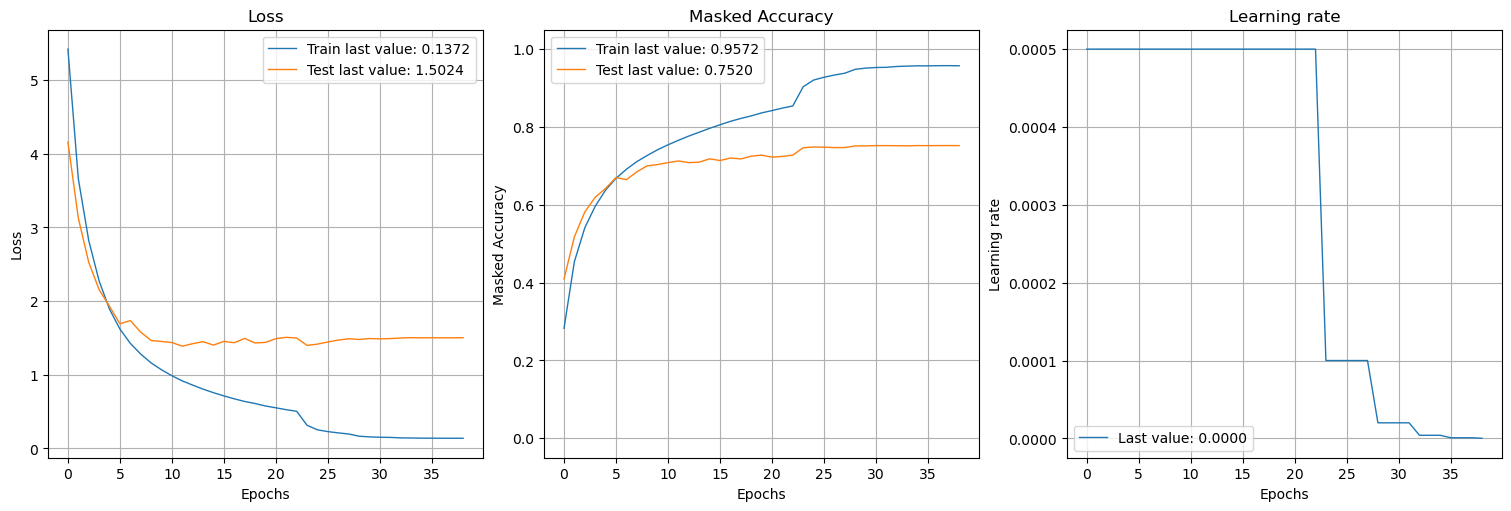

In [98]:
from plot_keras_history import show_history
show_history(history)

Scoring and inference definition.

To do inference we use the `BeamSampler` from keras nlp. This is an improvement from a greedy sampler (that takes as next word always the highest scoring one) because we're considering more than one possible sentence and we output the one with highest probability.

In [37]:
import keras_nlp

def decode_sequences(shuf_batch, sampler='greedy'):
    # Here we have that we pass a batch of shuffuled sentences and we get in
    # output a list of senteces.

    batch_size = tf.shape(shuf_batch)[0]

    # Define a function that outputs the next token's scores given the
    # input sequence (x).
    def next(x, cache, index):
        # This is only used when using the beam search
        # It duplicate the shuf_batch to match dimension with x
        if sampler == 'beam':
            beam_size = tf.shape(x)[0]
            shuf_next = tf.repeat(shuf_batch, repeats=beam_size//batch_size, axis=0)
        else:
            shuf_next = shuf_batch

        logits = transformer([shuf_next, x], use_mask=True)[:, index - 1, :]

        hidden_states = None  # with these samplers we don't need this
        return logits, hidden_states, cache

    length = SENTENCE_LENGTH
    start = tf.fill((batch_size, 1), sos)
    pad = tf.fill((batch_size, length - 1), 0) # 0 -> padding
    prompt = tf.concat((start, pad), axis=-1)



    if sampler == 'beam':
        samp = keras_nlp.samplers.BeamSampler(5) 
    elif sampler == 'greedy':
        samp = keras_nlp.samplers.GreedySampler()
    
    generated_tokens = samp(
        next=next,
        prompt=prompt,
        end_token_id=eos,
        index=1,  # Start sampling after start token.
    )

    generated_sentences = tokenizer.sequences_to_texts(generated_tokens.numpy())
    return generated_sentences

In [38]:
def create_string(sentences: list[str]):
  # we start from 8 because we have the start token
  # we find the <end> token and we stop one char before it to delete the space
  return [s[8:s.index('<end>')-1] for s in sentences]

In [39]:
def compute_final_score_batch(test_shuf, test_original, sampler='beam', indx_list=None, verbose=0):
  # Compute the final score on a batch of samples taken from the test_shuf array
  # This is because running inference on more than that gives OOM exception

  # First we start by sampling if no sample have been provided
  if indx_list is None:
    indx_list = np.random.choice(np.arange(len(test_shuf)), 100, replace=False)
  
  test_shuf = test_shuf[indx_list]
  test_original = test_original[indx_list]

  # Than we can create a tensor object for the shuf version
  # If we try to do directly with 3000 we get OOM exception so we need to split them
  test_tensor = tf.convert_to_tensor(test_shuf)
  # We predict
  if verbose >= 1:
    print("Starting prediction...")
  
  test_prediction_str = decode_sequences(test_tensor, sampler=sampler)
  
  if verbose >= 1:
    print("Predictoin completed")

  # We detokenize the output of the original data
  test_og_str = tokenizer.sequences_to_texts(test_original)
  
  # for both we create a list of raw strings
  test_prediction_raw = create_string(test_prediction_str)
  test_og_raw = create_string(test_og_str)

  # for each of the pairs we compute the score and take the mean
  if verbose >= 1:
    print("Starting scoring...")

  score_list = []
  for og, pred in zip(test_og_raw, test_prediction_raw):
    if verbose >= 2:
        print(score(og, pred))
    if verbose >= 3:
        print("og: ", og)
        print("pred: ", pred)
    score_list.append(score(og, pred))

  tot_score = sum(score_list) / len(score_list)

  return tot_score

In [40]:
def compute_final_score(test_shuf, test_original, sampler='beam', indx_list=None, verbose=0):
    # Compute the final score on 3K samples from the test

    batch_scores = []
    if indx_list is None:
        indx_list = np.random.choice(np.arange(len(test_shuf)), 3000, replace=False)

    for i in range(0, indx_list.shape[0], 100):
        if verbose >= 1:
            print(f"Computing score on {i}:{i+100}")
        batch_scores.append(compute_final_score_batch(test_shuf, test_original, indx_list=indx_list[i:i+100], sampler=sampler, verbose=verbose-1))
        if verbose >=1:
            print(f"Score = {batch_scores[-1]}")
    
    return sum(batch_scores) / len(batch_scores)

In [41]:
# Convert to tensor so that we can use them for inference
test_batch = tf.convert_to_tensor(c_test)
original_batch = tf.convert_to_tensor(x_test)

In [42]:
np.random.seed(583996) # we set a random seed for reproducibility
indx_list_full = np.random.choice(np.arange(len(c_test)), 3000, replace=False)

Score of the network trained on 80% of the training set. This is NOT the final score, we need to train on the whole train set.

In [100]:
compute_final_score(c_test, x_test, indx_list=indx_list_full, sampler="beam",verbose=0)

0.5386672235501635

Now we train on the whole training set so we need to change a bit the callbacks. Essentially the previous run was done to evaluate the model and get an idea of it's behavior, now that we know that is not prone to overfitting we just train until we reach the same number of epochs as in the previous fit.

In [46]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + 'callback_checkpts/' + f'{floor(time())}/' +'weights.{epoch:02d}-{masked_accuracy:.4f}.hdf5',
    save_weights_only=True,
    monitor='masked_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="masked_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=5
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='masked_accuracy', 
    factor=0.2,
    verbose=1,
    patience=4,
    min_lr=0.0000001,
    mode='max',
    min_delta=0.01
)

transformer = Transformer(
    num_enc_layers=num_enc_layers,
    num_dec_layers=num_dec_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCABULARY_SIZE,
    target_vocab_size=VOCABULARY_SIZE,
    dropout_rate=dropout_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history_full = transformer.fit(x=[c_train, x_train],
                               y =y_train,
                               batch_size=BATCH_SIZE,
                               epochs=40,  # We use around the same number of epochs as with the validation set
                               callbacks=[
                                  model_checkpoint_callback,
                                  early_stopping_callback,
                                  reduce_lr_callback
                               ])

Epoch 1/200
751/751 [==============================] - ETA: 0s - loss: 5.1053 - masked_accuracy: 0.3160
Epoch 1: masked_accuracy improved from -inf to 0.31600, saving model to ./DeepLearning/transformers_checkpoints/callback_checkpts/1686392236/weights.01-0.3160.hdf5
751/751 [==============================] - 250s 234ms/step - loss: 5.1053 - masked_accuracy: 0.3160 - lr: 5.0000e-04
Epoch 2/200
751/751 [==============================] - ETA: 0s - loss: 3.2842 - masked_accuracy: 0.4945
Epoch 2: masked_accuracy improved from 0.31600 to 0.49451, saving model to ./DeepLearning/transformers_checkpoints/callback_checkpts/1686392236/weights.02-0.4945.hdf5
751/751 [==============================] - 151s 201ms/step - loss: 3.2842 - masked_accuracy: 0.4945 - lr: 5.0000e-04
Epoch 3/200
751/751 [==============================] - ETA: 0s - loss: 2.4554 - masked_accuracy: 0.5771
Epoch 3: masked_accuracy improved from 0.49451 to 0.57708, saving model to ./DeepLearning/transformers_checkpoints/callback

Final score of the network. As we can see training on the whole training set improves the score.

In [ ]:
compute_final_score(c_test, x_test, indx_list=indx_list_full, sampler="beam",verbose=0)

0.5510725135510062